![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Linear Regression and Optimization

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/iwh-halle/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/iwh-halle/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

In this exercise we will compare the **DAX index** (.GDAXI) to a portfolio build from the **constituents** (the remaining columns).

### Task:

Find the vector of weights $\mathbf{w}$ for the [Minimum Variance Portfolio (MVP)](https://en.wikipedia.org/wiki/Modern_portfolio_theory) using only the constituents (not .GDAXI). Print risk ($\sigma$) and return ($\mu$) of both, DAX and MVP. Show in a single graph the cumulative log-returns of both portfolios. Please note that the sum of $\mathbf{w}$ must be $100$%. ALso, you are not allowed to use short positions, i.e. $w \ge 0\ \forall\ w \in \mathbf{w}$.

Hint: The portfolio variance - which we want to minimize - is given by
$$
\sigma^2_\text{Portfolio} = \mathbf{w}^\intercal \mathbf{\Sigma} \mathbf{w},
$$
where $\mathbf{\Sigma}$ is the correlation matrix of the portfolio constituents.

Optimale Gewichtungen: 
[0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103]
Minimale Portfolio-Varianz: 0.0002
Portfolio Return: 0.0005
Portfolio Risk: 0.0128
DAX Return: 0.0006
DAX Risk: 0.0121


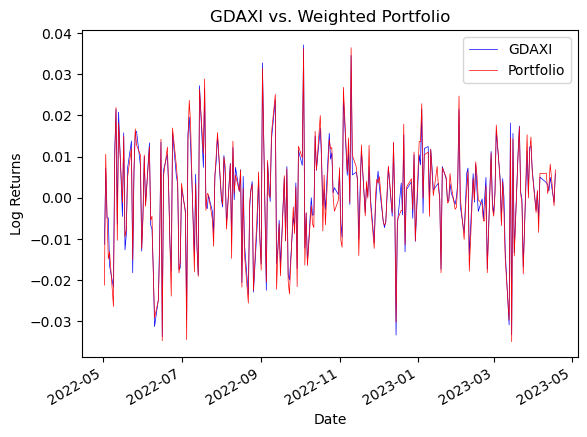

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Import the data
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

# Remove Dax from the data
prices_port = prices.iloc[:,1:]

# Calculate the returns
returns = prices_port.pct_change().dropna()

# calculate the covariance matrix
covariance_matrix = returns.cov()

# count stocks
num_stocks = len(returns.columns)

# set intiuial guess for the weights
initial_guess = np.ones(num_stocks) / num_stocks

# setting constraints for the optimization
# >0 constraint for all weights
bounds = [(0, 1)] * num_stocks

# Old: Question for tutorium: Why does the following function not work? --> Why do I need the bounds?
'''def non_negative_weights(weights):
    return weights'''

# sum of weights = 1
def sum_constraint(weights):
    return np.sum(weights) - 1.0

# set the constraint
cons = ({'type': 'eq', 'fun': sum_constraint})

# Old 
'''cons = {'type': 'eq', 'fun': sum_constraint,
       'type': 'ineq', 'fun': non_negative_weights}'''

# Define the objective function
def objective(weights):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))


# Minimize the objective function
result = minimize(objective, initial_guess, bounds=bounds, constraints=[cons])


# print results 
optimal_weights = result.x
min_variance = result.fun
# results are wrong, because the optimization is not working correctly

print("Optimale Gewichtungen: ",optimal_weights, sep='\n')
print(f"Minimale Portfolio-Varianz: {min_variance:,.4f}")


# Calculate the risk and return of the portfolio
portfolio_risk = np.sqrt(objective(optimal_weights))
portfolio_return = np.dot(optimal_weights.T, returns.mean())

# Calculate the risk and return of the DAX index
prices_dax = prices['.GDAXI']
returns_dax = prices_dax.pct_change().dropna()
mean_returns_GDAXI = returns_dax.mean()
std_returns_GDAXI = returns_dax.std()

print(f"Portfolio Return: {portfolio_return:,.4f}")
print(f"Portfolio Risk: {portfolio_risk:,.4f}")
print(f"DAX Return: {mean_returns_GDAXI:,.4f}")
print(f"DAX Risk: {std_returns_GDAXI:,.4f}")


logreturns = np.log(prices) - np.log(prices.shift(1))
logreturns = logreturns.dropna()
logreturns_port = pd.DataFrame(np.dot(logreturns.iloc[:,1:],optimal_weights), index=logreturns.index)
logreturns_dax = pd.DataFrame(logreturns.iloc[:,:1])

# setting the labels in the plot does not work correctly, thats why I change the column names
logreturns_dax = logreturns_dax.rename(columns={'.GDAXI': 'GDAXI'})
logreturns_port = logreturns_port.rename(columns={logreturns_port.columns[0] : 'Portfolio'})

# Plot 
ax = logreturns_dax.plot(linewidth=0.5, color='blue', label='GDAXI')
logreturns_port.plot(ax=ax, linewidth=0.5, color='red', label='Portfolio')
plt.legend(loc='upper right')
plt.title('GDAXI vs. Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.savefig('05_optimization_Log_Returns.png')
plt.show()

### Task:

Use a linear regression model to find the actual weights of the index constituents that are required to replicate (i.e. explain) the returns of the DAX index. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

Replicating Portfolio Mean Return: 0.0006
Replicating Portfolio Risk: 0.0120
DAX Mean Return: 0.0006
DAX Risk: 0.0121


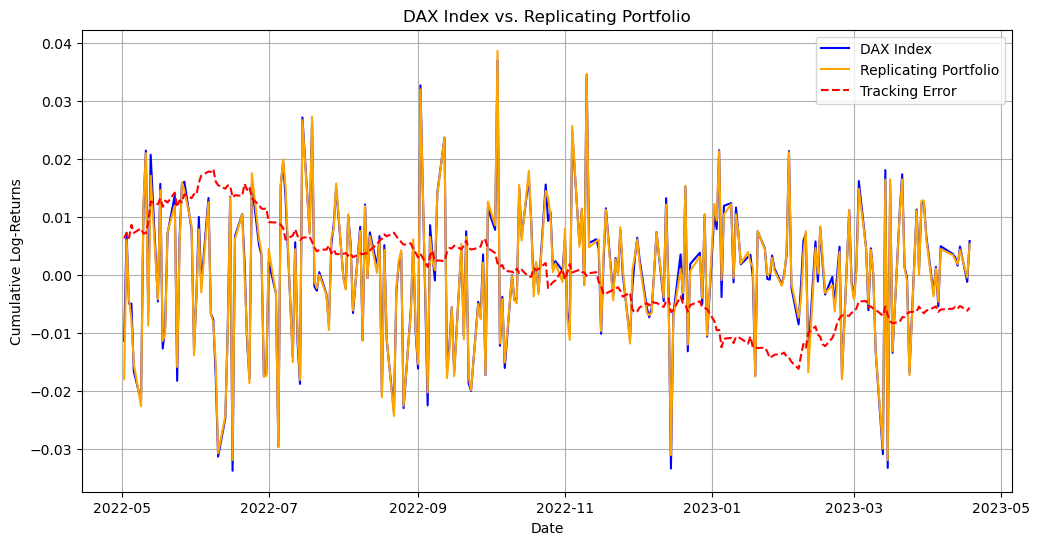

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Import the data
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

# Portfolio data
prices_port = prices.iloc[:,1:]
returns_port = prices_port.pct_change().dropna()

# Dax data
prices_dax = prices.iloc[:,0]
returns_dax = prices_dax.pct_change().dropna()


# Fit linear regression model
model = LinearRegression()
model.fit(returns_port, returns_dax)

# Get the coefficients (weights) of the regression model
constituent_weights = model.coef_

# Calculate returns of the replicating portfolio
replicating_portfolio_returns = np.dot(returns_port, constituent_weights)
replicating_portfolio_cumulative_returns = replicating_portfolio_returns.cumsum() # not directly used in the grap but in the tracking error
replicating_portfolio_risk = np.std(replicating_portfolio_returns)
replicating_portfolio_mean_return = np.mean(replicating_portfolio_returns)

print(f"Replicating Portfolio Mean Return: {replicating_portfolio_mean_return:,.4f}")
print(f"Replicating Portfolio Risk: {replicating_portfolio_risk:,.4f}")

# Calculate risk and return of the DAX index
dax_cumulative_returns = returns_dax.cumsum()
dax_risk = np.std(returns_dax)
dax_mean_return = np.mean(returns_dax)
print(f"DAX Mean Return: {dax_mean_return:,.4f}")
print(f"DAX Risk: {dax_risk:,.4f}")


logreturns = np.log(prices) - np.log(prices.shift(1))
logreturns = logreturns.dropna()
logreturns_port = pd.DataFrame(np.dot(logreturns.iloc[:,1:],constituent_weights), index=logreturns.index)
logreturns_dax = pd.DataFrame(logreturns.iloc[:,:1])


# Plotting
plt.figure(figsize=(12, 6))

# Plot cumulative log-returns of DAX index and replicating portfolio
plt.plot(dax_cumulative_returns.index, logreturns_dax, label='DAX Index', color='blue')
plt.plot(dax_cumulative_returns.index, logreturns_port, label='Replicating Portfolio', color='orange')

# Calculate tracking error
tracking_error = dax_cumulative_returns - replicating_portfolio_cumulative_returns

# Plot tracking error
plt.plot(tracking_error.index, tracking_error, label='Tracking Error', color='red', linestyle='--')

plt.title('DAX Index vs. Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')
plt.legend()
plt.grid(True)
plt.show()


### Task:

We want to create a ["smart-beta"](https://en.wikipedia.org/wiki/Smart_beta) strategy that replicates the DAX index returns using only a subset of its constituents. This is, maximize the fit of the model using only $3$ constituents. This process is similar to [feature selection](https://en.wikipedia.org/wiki/Feature_selection) in machine learning. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

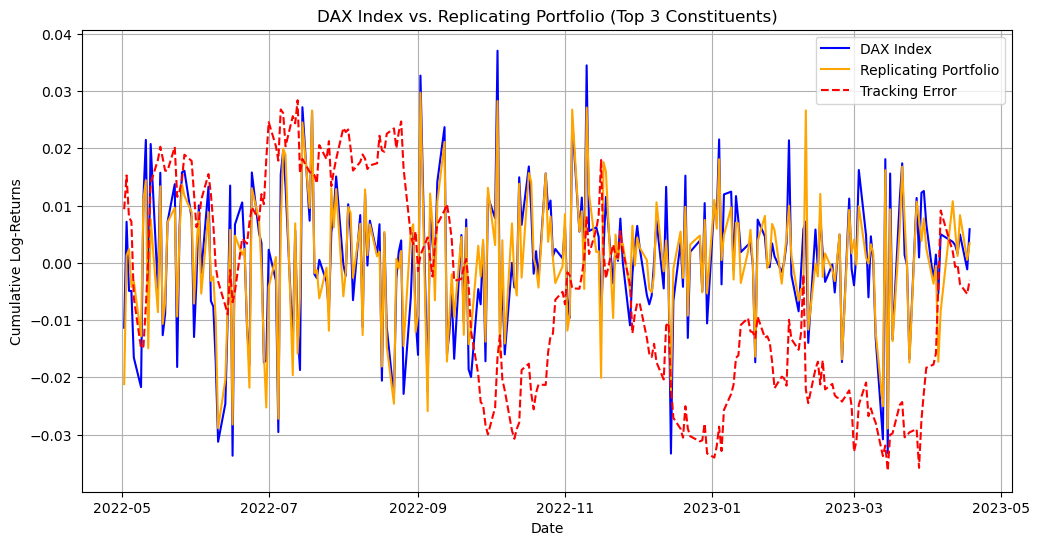

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Import the data
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

# Portfolio data
prices_port = prices.iloc[:,1:]
returns_port = prices_port.pct_change().dropna()

# Dax data
prices_dax = prices.iloc[:,0]
returns_dax = prices_dax.pct_change().dropna()


# Fit linear regression model
model = LinearRegression()
model.fit(returns_port, returns_dax)

# Feature Selection
# Select top 3 constituents based on some criteria (e.g., highest correlation with the index)
correlation_with_index = returns_port.corrwith(returns_dax)
top_3_constituents = correlation_with_index.abs().nlargest(3).index
selected_constituents_returns = returns_port[top_3_constituents]

# Linear Regression
# Fit linear regression model
model = LinearRegression()
model.fit(selected_constituents_returns, returns_dax)

# Get the coefficients (weights) of the regression model
constituent_weights = model.coef_

# Calculate Risk and Return
# Calculate returns of the replicating portfolio
replicating_portfolio_returns = np.dot(selected_constituents_returns, constituent_weights)
replicating_portfolio_cumulative_returns = replicating_portfolio_returns.cumsum()

# Calculate risk and return of the DAX index
dax_cumulative_returns = returns_dax.cumsum()


logreturns = np.log(prices) - np.log(prices.shift(1))
logreturns = logreturns.dropna()
logreturns_dax = pd.DataFrame(logreturns.iloc[:,:1])
logreturns_port = pd.DataFrame(np.dot(logreturns[top_3_constituents],constituent_weights), index=logreturns.index)


# Plotting
plt.figure(figsize=(12, 6))

# Plot cumulative log-returns of DAX index and replicating portfolio
plt.plot(dax_cumulative_returns.index, logreturns_dax, label='DAX Index', color='blue')
plt.plot(dax_cumulative_returns.index, logreturns_port, label='Replicating Portfolio', color='orange')

# Calculate tracking error
tracking_error = dax_cumulative_returns - replicating_portfolio_cumulative_returns

# Plot tracking error
plt.plot(tracking_error.index, tracking_error, label='Tracking Error', color='red', linestyle='--')

plt.title('DAX Index vs. Replicating Portfolio (Top 3 Constituents)')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')
plt.legend()
plt.grid(True)
plt.show()
